# Boost CV LB +0.2 with RAPIDS SVR Head
In this notebook, we demonstrate how to add a RAPIDS SVR second head to an already trained CNN or Image Transformer with first head. This boosts CV LB by +0.2! This trick was used in CommonLit Comp [here][3] to boost our team into Gold Medal!

We begin with [Abhishek's][2] public notebook [here][1] which already contains a fully trained Image Transformer model (with NN head). Now in this notebook, we extract the image embeddings (from the trained fold models) and train additional RAPIDS SVR heads for each fold. The original NN head achieves overall CV RSME 18.0 and the new RAPIDS SVR head achieves overall CV RSME 18.0. Both heads are very diverse because the NN head uses Classification (BCE) loss and the SVR head uses Regression loss. During inference, we predict with both heads. When we average both heads' predictions, we achieve overall CV RSME 17.8!

The technique illustrated here can be applied to any trained image (or NLP) model for CV LB boost! In the first version of this notebook, we train the SVR heads and save the fold models. Then, in later notebook versions and during Kaggle submission, we load the saved SVR models (from this notebook's version 1 which was made into a Kaggle dataset).

[1]: https://www.kaggle.com/abhishek/tez-pawpular-swin-ference
[2]: https://www.kaggle.com/abhishek
[3]: https://www.kaggle.com/c/commonlitreadabilityprize/discussion/260800

# How to Add RAPIDS SVR Head
There are 3 steps to building a double headed model. The first step is to train your Image NN backbone and head. This was done by Abhishek in his notebook [here][1] and achieves CV RSME 18.0. The next step is to train our RAPIDS SVR head with extracted embeddings from frozen Image NN backbone. This is done in version 1 of notebook you are reading [here][2] and achieves CV RSME 18.0. Lastly, we infer with both heads and average the predictions. This is done in the notebook you are reading and achieves CV RSME 17.8!

![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Oct-2021/st1.png)
![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Oct-2021/st2.png)
![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Oct-2021/st3.png)

[1]: https://www.kaggle.com/abhishek/tez-pawpular-swin-ference
[2]: https://www.kaggle.com/cdeotte/rapids-svr-boost-17-8?scriptVersionId=76282086

# Load Libraries

In [1]:
# based on the post here: https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/275094

import sys

sys.path.append("../input/tez-lib/")
sys.path.append("../input/timmmaster/")

import tez
import albumentations
import pandas as pd
import cv2
import numpy as np
import timm
import torch.nn as nn
from sklearn import metrics
import torch
from tez.callbacks import EarlyStopping
from tqdm import tqdm
import math
# Asthetics
import warnings
import sklearn.exceptions

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import os
import glob
import random
import cv2

pd.set_option('display.max_columns', None)

# Image Aug
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

# Deep Learning
import torch
import torchvision
import timm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Random Seed Initialize
RANDOM_SEED = 42


def seed_everything(seed=RANDOM_SEED):
	os.environ['PYTHONHASHSEED'] = str(seed)
	np.random.seed(seed)
	random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = True


seed_everything()

# Device Optimization
if torch.cuda.is_available():
	device = torch.device('cuda')
else:
	device = torch.device('cpu')

print(f'Using device: {device}')


class args:
	batch_size = 16
	image_size = 384


def sigmoid(x):
	return 1 / (1 + math.exp(-x))

# Define Swim Model and Swim Dataset

In [1]:
csv_dir = '../input/petfinder-pawpularity-score'
test_dir = '../input/petfinder-pawpularity-score/test'
models_dir = '../input/swin-transformenrs-pet-net'

test_file_path = os.path.join(csv_dir, 'test.csv')
sample_sub_file_path = os.path.join(csv_dir, 'sample_submission.csv')
print(f'Test file: {test_file_path}')
print(f'Models path: {models_dir}')
test_df = pd.read_csv(test_file_path)
sample_df = pd.read_csv(sample_sub_file_path)


def return_filpath(name, folder):
	path = os.path.join(folder, f'{name}.jpg')
	return path


test_df['image_path'] = test_df['Id'].apply(lambda x: return_filpath(x, folder=test_dir))


class CuteDataset(Dataset):
	def __init__(self, images_filepaths, dense_features, targets, transform=None):
		self.images_filepaths = images_filepaths
		self.dense_features = dense_features
		self.targets = targets
		self.transform = transform

	def __len__(self):
		return len(self.images_filepaths)

	def __getitem__(self, idx):
		image_filepath = self.images_filepaths[idx]
		image = cv2.imread(image_filepath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

		if self.transform is not None:
			image = self.transform(image=image)['image']

		dense = self.dense_features[idx, :]
		label = torch.tensor(self.targets[idx]).float()
		return image, dense, label

def get_test_transforms(DIM = params['im_size']):
    return albumentations.Compose(
        [
          albumentations.Resize(DIM,DIM),
          albumentations.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
          ),
          ToTensorV2(p=1.0)
        ]
    )
class PetNet(nn.Module):
	def __init__(self, model_name=params['model'], out_features=params['out_features'],
	             inp_channels=params['inp_channels'],
	             pretrained=params['pretrained'], num_dense=len(params['dense_features'])):
		super().__init__()
		self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=inp_channels)
		n_features = self.model.head.in_features
		self.model.head = nn.Linear(n_features, 128)
		self.fc = nn.Sequential(
			nn.Linear(128 + num_dense, 64),
			nn.ReLU(),
			nn.Linear(64, out_features)
		)
		self.dropout = nn.Dropout(0.2)

	def forward(self, image, dense):
		embeddings = self.model(image)
		x = self.dropout(embeddings)
		x = torch.cat([x, dense], dim=1)
		output = self.fc(x)
		return output



NameError: name 'os' is not defined

# Import RAPIDS

In [3]:
import cuml, pickle
from cuml.svm import SVR

print('RAPIDS version', cuml.__version__, '\n')

LOAD_SVR_FROM_PATH = '../input/svr-models-10-folds/'

df = pd.read_csv('../input/same-old-creating-folds/train_10folds.csv')
print('Train shape:', df.shape)
df.head()

RAPIDS version 21.08.01 

Train shape: (9912, 15)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,kfold
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,1
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,5
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,1
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,6
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,8


# Infer Test and OOF
In version 1 of this notebook, we extract train embeddings and train RAPIDS SVR heads. (Click version 1 to see this). In later versions and during Kaggle submit, we load these saved RAPIDS SVR fold models and just infer data (without training anything).

In [4]:
super_final_predictions = []
super_final_predictions2 = []
super_final_oof_predictions = []
super_final_oof_predictions2 = []
super_final_oof_true = []

for fold_ in range(10):
	print('#' * 25)
	print('### FOLD', fold_ + 1)
	print('#' * 25)

	model = PawpularModel(model_name="swin_large_patch4_window12_384")
	model.load(f"../input/paw-models/model_f{fold_}.bin", device="cuda", weights_only=True)

	df_test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
	test_img_paths = [f"../input/petfinder-pawpularity-score/test/{x}.jpg" for x in df_test["Id"].values]

	df_valid = df[df.kfold == fold_].reset_index(drop=True)  #.iloc[:160]
	valid_img_paths = [f"../input/petfinder-pawpularity-score/train/{x}.jpg" for x in df_valid["Id"].values]

	dense_features = [
		'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
		'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
	]

	name = f"SVR_fold_{fold_}.pkl"
	if LOAD_SVR_FROM_PATH is None:
		##################
		# EXTRACT TRAIN EMBEDDINGS

		df_train = df[df.kfold != fold_].reset_index(drop=True)  #.iloc[:320]
		train_img_paths = [f"../input/petfinder-pawpularity-score/train/{x}.jpg" for x in df_train["Id"].values]

		train_dataset = PawpularDataset(
			image_paths=train_img_paths,
			dense_features=df_train[dense_features].values,
			targets=df_train['Pawpularity'].values / 100.0,
			augmentations=test_aug,
		)
		print('Extracting train embedding...')
		train_predictions = model.predict(train_dataset, batch_size=2 * args.batch_size, n_jobs=-1)

		embed = np.array([]).reshape((0, 128 + 12))
		for preds in train_predictions:
			embed = np.concatenate([embed, preds[:, 1:]], axis=0)

		##################
		# FIT RAPIDS SVR
		print('Fitting SVR...')
		clf = SVR(C=20.0)
		clf.fit(embed.astype('float32'), df_train.Pawpularity.values.astype('int32'))

		##################
		# SAVE RAPIDS SVR
		pickle.dump(clf, open(name, "wb"))

	else:
		##################
		# LOAD RAPIDS SVR
		print('Loading SVR...', LOAD_SVR_FROM_PATH + name)
		clf = pickle.load(open(LOAD_SVR_FROM_PATH + name, "rb"))

	##################
	# TEST PREDICTIONS
	test_dataset = PawpularDataset(
		image_paths=test_img_paths,
		dense_features=df_test[dense_features].values,
		targets=np.ones(len(test_img_paths)),
		augmentations=test_aug,
	)
	print('Predicting test...')
	test_predictions = model.predict(test_dataset, batch_size=2 * args.batch_size, n_jobs=-1)

	final_test_predictions = []
	embed = np.array([]).reshape((0, 128 + 12))
	for preds in test_predictions:  #tqdm
		final_test_predictions.extend(preds[:, :1].ravel().tolist())
		embed = np.concatenate([embed, preds[:, 1:]], axis=0)

	final_test_predictions = [sigmoid(x) * 100 for x in final_test_predictions]
	final_test_predictions2 = clf.predict(embed)
	super_final_predictions.append(final_test_predictions)
	super_final_predictions2.append(final_test_predictions2)
	##################

	##################
	# OOF PREDICTIONS
	valid_dataset = PawpularDataset(
		image_paths=valid_img_paths,
		dense_features=df_valid[dense_features].values,
		targets=df_valid['Pawpularity'].values / 100.0,
		augmentations=test_aug,
	)
	print('Predicting oof...')
	valid_predictions = model.predict(valid_dataset, batch_size=2 * args.batch_size, n_jobs=-1)

	final_oof_predictions = []
	embed = np.array([]).reshape((0, 128 + 12))
	for preds in valid_predictions:
		final_oof_predictions.extend(preds[:, :1].ravel().tolist())
		embed = np.concatenate([embed, preds[:, 1:]], axis=0)

	final_oof_predictions = [sigmoid(x) * 100 for x in final_oof_predictions]
	final_oof_predictions2 = clf.predict(embed)
	super_final_oof_predictions.append(final_oof_predictions)
	super_final_oof_predictions2.append(final_oof_predictions2)

	final_oof_true = df_valid['Pawpularity'].values
	super_final_oof_true.append(final_oof_true)
	##################

	##################
	# COMPUTE RSME
	rsme = np.sqrt(np.mean((super_final_oof_true[-1] - np.array(super_final_oof_predictions[-1])) ** 2.0))
	print('NN RSME =', rsme, '\n')
	rsme = np.sqrt(np.mean((super_final_oof_true[-1] - np.array(super_final_oof_predictions2[-1])) ** 2.0))
	print('SVR RSME =', rsme, '\n')

	w = 0.5
	oof2 = (1 - w) * np.array(super_final_oof_predictions[-1]) + w * np.array(super_final_oof_predictions2[-1])
	rsme = np.sqrt(np.mean((super_final_oof_true[-1] - oof2) ** 2.0))
	print('Ensemble RSME =', rsme, '\n')

#########################
### FOLD 1
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_0.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.26it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:44<00:00,  1.43s/it, stage=test]


NN RSME = 17.97249498279356 

SVR RSME = 18.40609834338012 

Ensemble RSME = 17.968745575801634 

#########################
### FOLD 2
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_1.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.63it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:44<00:00,  1.42s/it, stage=test]


NN RSME = 18.237516564542965 

SVR RSME = 18.154424033265304 

Ensemble RSME = 18.024874255090868 

#########################
### FOLD 3
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_2.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.59it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:43<00:00,  1.42s/it, stage=test]


NN RSME = 18.135574783984232 

SVR RSME = 18.590583828229306 

Ensemble RSME = 18.220572472149556 

#########################
### FOLD 4
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_3.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.55it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:43<00:00,  1.42s/it, stage=test]


NN RSME = 18.282065537302437 

SVR RSME = 18.716292483881585 

Ensemble RSME = 18.30596892630058 

#########################
### FOLD 5
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_4.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.57it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:44<00:00,  1.42s/it, stage=test]


NN RSME = 18.511256950972676 

SVR RSME = 18.71897535397874 

Ensemble RSME = 18.366604806188537 

#########################
### FOLD 6
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_5.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.45it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:44<00:00,  1.43s/it, stage=test]


NN RSME = 17.671787422815502 

SVR RSME = 17.884242919038655 

Ensemble RSME = 17.67141776634974 

#########################
### FOLD 7
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_6.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.51it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:44<00:00,  1.42s/it, stage=test]


NN RSME = 18.22703568076969 

SVR RSME = 17.67076317069654 

Ensemble RSME = 17.545838829310828 

#########################
### FOLD 8
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_7.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.47it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:43<00:00,  1.42s/it, stage=test]


NN RSME = 17.492799323859824 

SVR RSME = 17.423998301280427 

Ensemble RSME = 17.237742032404697 

#########################
### FOLD 9
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_8.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.60it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:43<00:00,  1.42s/it, stage=test]


NN RSME = 18.221953403634856 

SVR RSME = 17.98396810662354 

Ensemble RSME = 17.796442925973505 

#########################
### FOLD 10
#########################
Loading SVR... ../input/svr-models-10-folds/SVR_fold_9.pkl
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.59it/s, stage=test]


Predicting oof...


100%|██████████| 31/31 [00:44<00:00,  1.42s/it, stage=test]

NN RSME = 18.16202634654475 

SVR RSME = 17.440837375565522 

Ensemble RSME = 17.53770280684388 



# Compute CV Score
Below we compute the overall CV RSME scores of just the NN head, just the SVR head, and an ensemble of 50% NN and 50% SVR heads. Then we plot all ensemble weights to find the optimal weights for NN head and SVR heads.

In [5]:
true = np.hstack(super_final_oof_true)

oof = np.hstack(super_final_oof_predictions)
rsme = np.sqrt(np.mean((oof - true) ** 2.0))
print('Overall CV NN head RSME =', rsme)

oof2 = np.hstack(super_final_oof_predictions2)
rsme = np.sqrt(np.mean((oof2 - true) ** 2.0))
print('Overall CV SVR head RSME =', rsme)

oof3 = (1 - w) * oof + w * oof2
rsme = np.sqrt(np.mean((oof3 - true) ** 2.0))
print('Overall CV Ensemble heads RSME with 50% NN and 50% SVR =', rsme)

Overall CV NN head RSME = 18.093733135357894
Overall CV SVR head RSME = 18.10523005264604
Overall CV Ensemble heads RSME with 50% NN and 50% SVR = 17.871123517721248


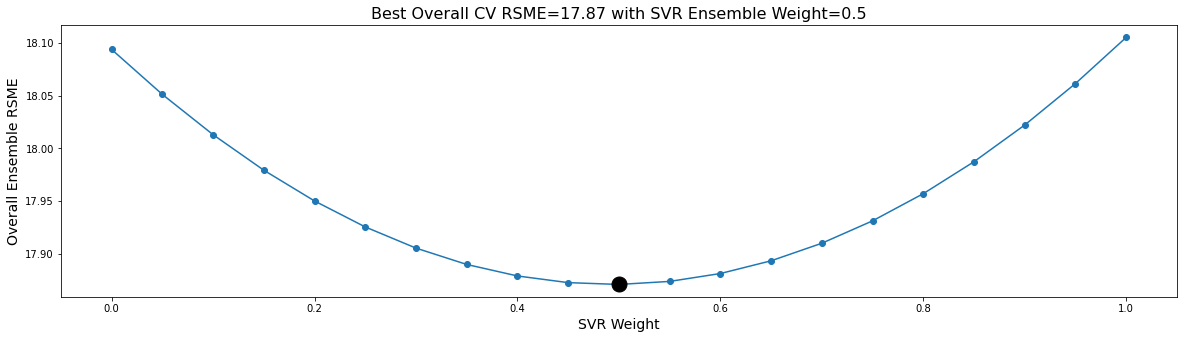

In [6]:
import matplotlib.pyplot as plt

score = []
for ww in np.arange(0, 1.05, 0.05):
	oof3 = (1 - ww) * oof + ww * oof2
	rsme = np.sqrt(np.mean((oof3 - true) ** 2.0))
	#print(f'{ww:0.2} CV Ensemble RSME =',rsme)
	score.append(rsme)
best_w = np.argmin(score) * 0.05

plt.figure(figsize=(20, 5))
plt.plot(np.arange(21) / 20.0, score, '-o')
plt.plot([best_w], np.min(score), 'o', color='black', markersize=15)
plt.title(f'Best Overall CV RSME={np.min(score):.4} with SVR Ensemble Weight={best_w:.2}', size=16)
plt.ylabel('Overall Ensemble RSME', size=14)
plt.xlabel('SVR Weight', size=14)
plt.show()

# Trust CV or LB?
Above we see that using 50% NN head and 50% SVR head achieves the best overall CV score. However our RAPIDS SVR head isn't helping public LB much. We also notice that our RAPIDS SVR head helped folds `1, 2, 4, 5, 7, 8, 9, 10` but did not help folds `3, 6`. So is public test data just a "bad fold"? Will our RAPIDS SVR head help private LB? Below we force the weight of SVR head to be 10% in order to achieve a slight public LB boost. But maybe for final submission, we should use 50%??

In [7]:
# FORCE SVR WEIGHT TO LOWER VALUE TO HELP PUBLIC LB
best_w = 0.2

# Make Submission CSV
We make a submission csv using an ensemble of both heads. We use the optimal ensemble weights that we discovered above.

In [8]:
super_final_predictions = np.mean(np.column_stack(super_final_predictions), axis=1)
super_final_predictions2 = np.mean(np.column_stack(super_final_predictions2), axis=1)
df_test["Pawpularity"] = (1 - best_w) * super_final_predictions + best_w * super_final_predictions2
df_test = df_test[["Id", "Pawpularity"]]
df_test.to_csv("submission.csv", index=False)
df_test.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,37.533920
1,43a2262d7738e3d420d453815151079e,37.225172
2,4e429cead1848a298432a0acad014c9d,36.200547
3,80bc3ccafcc51b66303c2c263aa38486,36.226596
4,8f49844c382931444e68dffbe20228f4,36.333241
